In [1]:
import pandas as pd
import numpy as np
import math

# Methodology
We implement the following methodology to create a uniform measure of forecasting ability:
- __Forecast evaluation__:
    - __Scale forecasts__: unitize forecast vector by taking scores, dot-prod with its transpose, divide forecast by sqrt of ratio;
    - __Calculate periodic returns__: for each period: take scaled forecast at beginning of period, multiply by end of period asset-return to give asset-level ‘model-return’; sum to get portfolio-level ‘model-return’;
    - __Calculate cumulative returns__: multiply portfolio-level ‘model-return’ return across all periods to get total ‘model-return’ across backtest timeline.

__Note__: This is an __unconstrained__ measure of performance, not considering risk adjustments and trading costs at this point. The measure of performance is relative and used to compare the different strategies, it does not equate to a monetary value.

----

# Load in Data

In [13]:
returns = pd.read_csv('returns_example_data.csv', index_col=0, parse_dates=True)
returns.head()

,X0000,X0001,X0002,X0003,X0004,X0005,X0006,X0007,X0008,X0009,...,X0090,X0091,X0092,X0093,X0094,X0095,X0096,X0097,X0098,X0099
period,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.010908,0.000334,-0.000586,-0.006591,0.007305,-0.003786,0.005338,-0.001945,0.001255,0.013255,...,-0.014357,-0.012908,-0.005885,-0.009846,0.011709,0.000920,0.012995,0.011962,-0.000764,-0.001065
2018-01-02,0.007013,-0.003659,0.003218,-0.010403,0.020972,0.010219,0.000778,0.004748,0.003741,0.007320,...,0.007063,-0.004894,0.004412,0.007874,0.000113,0.009033,0.010397,-0.003984,0.005255,0.020058
2018-01-03,0.004695,-0.004861,0.019964,-0.001419,-0.005983,0.000125,-0.015753,0.013186,0.009251,0.000606,...,-0.002106,-0.005763,0.007291,0.026858,-0.003325,-0.021504,-0.022193,0.018268,-0.007994,0.010453
2018-01-04,-0.015665,-0.002899,0.011327,0.019781,0.004744,0.002890,-0.004013,0.006394,0.022979,0.015575,...,0.021140,-0.017054,0.012061,0.012999,-0.006308,0.007687,0.011646,0.010349,-0.006598,-0.002679
2018-01-05,0.001149,0.005960,-0.013397,0.002911,-0.018057,0.003730,0.007247,-0.012295,0.003293,-0.001851,...,0.008990,0.007926,-0.008188,0.003563,-0.010347,-0.001241,0.003493,0.007976,0.006351,0.000265


In [28]:
forecasts = pd.read_csv('forecast_example_data.csv', index_col=0, parse_dates=True)
forecasts.head()

,X0000,X0001,X0002,X0003,X0004,X0005,X0006,X0007,X0008,X0009,...,X0090,X0091,X0092,X0093,X0094,X0095,X0096,X0097,X0098,X0099
period,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-2.107066,0.143936,-2.454639,-0.585614,-1.370174,-0.757645,-2.195033,0.244954,1.977399,1.771116,...,-0.743485,0.348614,-0.431445,4.395474,1.325933,-3.754003,-1.197294,-1.719758,-0.176842,-2.394018
2018-01-02,2.617617,-0.924026,0.652346,2.629858,0.304073,-5.356134,0.526060,0.467860,1.664121,0.550999,...,2.414521,-0.107721,-0.661561,-2.636892,-1.109693,0.359117,-1.182784,-1.648104,0.713900,1.753632
2018-01-03,-2.346082,-1.027965,1.325110,3.547902,3.533142,-0.010182,-3.707546,-0.376756,-0.552376,-1.441660,...,0.563521,-0.202065,3.103828,-2.702157,-1.454736,0.858888,-1.388349,2.304567,-2.244748,0.863345
2018-01-04,1.345747,2.661427,2.028670,-0.575971,-2.096493,2.940540,3.307477,1.562727,0.999004,0.419512,...,-2.130224,1.784122,-0.804171,0.709902,0.771744,-1.388993,0.913326,-0.733080,-3.139460,-1.182151
2018-01-05,-1.819045,1.636994,-0.313652,1.115260,0.154416,-1.318836,-0.587513,-1.227160,0.579190,2.622040,...,0.140813,0.223872,0.813251,-1.462279,0.797072,-1.886018,2.467804,1.277751,4.153122,1.002937


----

# Forecast evaluation

#### Provide scaling for forecasts

To keep models comparable, all forecast vectors are scaled. Specifically we scale them to the same size (`== 1.0` in multi-dimensional space). This does not translate your scores to e.g. probabilites nor holdings, it only calibrates scores to the same factor.

In [15]:
def scale_vect(scores):
    unit_ratio = np.dot(scores, np.transpose(scores)) ## Performs Matrix Multiplication
    return np.divide(scores, math.sqrt(unit_ratio))

In [16]:
# Example Scaled Vector
some_vect = np.array(range(-10, 10))
some_vect_scaled = scale_vect(some_vect)
some_vect_scaled

array([-0.3863337 , -0.34770033, -0.30906696, -0.27043359, -0.23180022,
       -0.19316685, -0.15453348, -0.11590011, -0.07726674, -0.03863337,
        0.        ,  0.03863337,  0.07726674,  0.11590011,  0.15453348,
        0.19316685,  0.23180022,  0.27043359,  0.30906696,  0.34770033])

### Calculate periodic returns

For every period: retrieve forecast scores, scale them, and multiply them by realised returns

In [29]:
model_returns = pd.DataFrame(data=[scale_vect(forecasts.loc[p]) * returns.loc[p] for p in returns.index], index=returns.index)
model_returns.head()

,X0000,X0001,X0002,X0003,X0004,X0005,X0006,X0007,X0008,X0009,...,X0090,X0091,X0092,X0093,X0094,X0095,X0096,X0097,X0098,X0099
period,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.001381,0.000003,0.000086,0.000232,-0.000601,1.723538e-04,-0.000704,-0.000029,0.000149,0.001410,...,0.000641,-0.000270,0.000153,-0.002600,0.000933,-0.000207,-0.000935,-0.001236,0.000008,0.000153
2018-01-02,0.000940,0.000173,0.000108,-0.001401,0.000327,-2.803547e-03,0.000021,0.000114,0.000319,0.000207,...,0.000873,0.000027,-0.000150,-0.001063,-0.000006,0.000166,-0.000630,0.000336,0.000192,0.001802
2018-01-03,-0.000595,0.000270,0.001430,-0.000272,-0.001142,-6.873253e-08,0.003156,-0.000268,-0.000276,-0.000047,...,-0.000064,0.000063,0.001223,-0.003922,0.000261,-0.000998,0.001665,0.002275,0.000970,0.000488
2018-01-04,-0.001066,-0.000390,0.001162,-0.000576,-0.000503,4.296443e-04,-0.000671,0.000505,0.001160,0.000330,...,-0.002276,-0.001538,-0.000490,0.000466,-0.000246,-0.000540,0.000538,-0.000384,0.001047,0.000160
2018-01-05,-0.000109,0.000508,0.000219,0.000169,-0.000145,-2.563043e-04,-0.000222,0.000786,0.000099,-0.000253,...,0.000066,0.000092,-0.000347,-0.000271,-0.000430,0.000122,0.000449,0.000531,0.001374,0.000014


For every period: sum over whole universe and get value

In [30]:
model_returns_sum = 1.0 + model_returns.sum(axis='columns')
model_returns_sum.head()

period
2018-01-01    0.993617
2018-01-02    1.001985
2018-01-03    1.014654
2018-01-04    0.993291
2018-01-05    1.006914
dtype: float64

### Calculate cumulative returns

In [31]:
cumulative_returns = model_returns_sum.cumprod()
cumulative_returns.head()

period
2018-01-01    0.993617
2018-01-02    0.995589
2018-01-03    1.010179
2018-01-04    1.003401
2018-01-05    1.010338
dtype: float64

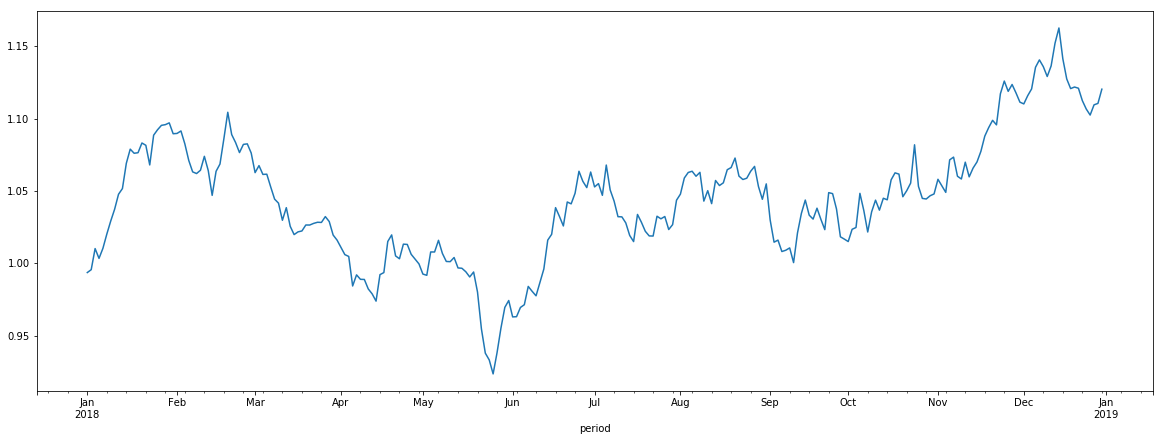

In [32]:
cumulative_returns.plot(figsize=(20,7))

In [33]:
cumulative_returns.tail(1)

period
2018-12-31    1.120286
dtype: float64